In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


In [3]:
data = pd.read_csv('microsoftdata.csv')
data = data.rename(columns={'Close(t)':'Close'})

data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,03/01/2022,335.350006,338.000000,329.779999,334.750000,328.120880,28865100
1,04/01/2022,334.829987,335.200012,326.119995,329.010010,322.494568,32674300
2,05/01/2022,325.859985,326.070007,315.980011,316.380005,310.114654,40054300
3,06/01/2022,313.149994,318.700012,311.489990,313.880005,307.664154,39646100
4,07/01/2022,314.149994,316.500000,310.089996,314.040008,307.820984,32720000


In [4]:
data.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
496,22/12/2023,373.679993,375.179993,372.709992,374.579987,373.888580,17091100
497,26/12/2023,375.000000,376.940002,373.500000,374.660004,373.968445,12673100
498,27/12/2023,373.690002,375.059998,372.809998,374.070007,373.379547,14905400
499,28/12/2023,375.369995,376.459992,374.160004,375.279999,374.587280,14327000
500,29/12/2023,376.000000,377.160004,373.480011,376.040008,375.345886,18723000


In [5]:
# Calculate the 50-day moving average
data['50_MA'] = data['Close'].rolling(window=30).mean()

# Calculate the 20-day Bollinger Band
data['20_STD'] = data['Close'].rolling(window=20).std()
data['Upper_Band'] = data['High'] + 2 * data['20_STD']
data['Lower_Band'] = data['Low'] - 2 * data['20_STD']

# Calculate previous low and high
data['Prev_Low'] = data['Low'].shift(-1)
data['Prev_High'] = data['High'].shift(-1)

# Generate buy and sell signals using Aroon
data['aroon_bull'] = 100 * data['High'].rolling(window=14).apply(lambda x: x.argmax()) / 14
data['aroon_bear'] = 100 * data['Low'].rolling(window=14).apply(lambda x: x.argmin()) / 14

data['Buy_Signal'] = np.where((data['Close'] > data['50_MA']) & (data['aroon_bull'] > data['aroon_bear']), 1, 0)
data['Sell_Signal'] = np.where((data['Close'] < data['50_MA']) & (data['aroon_bear'] > data['aroon_bull']), -1, 0)

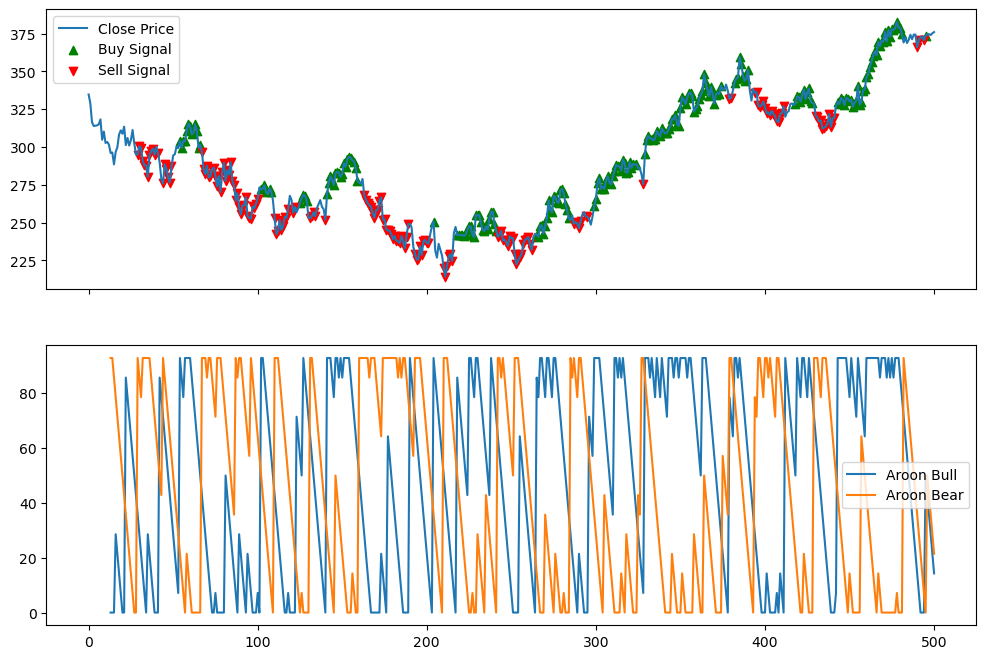

In [6]:
# Plot the signals
def plot_signals(data):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    ax1.plot(data['Close'], label='Close Price')
    ax1.scatter(data.index[data['Buy_Signal'] == 1], data['Close'][data['Buy_Signal'] == 1], color='green', marker='^', label='Buy Signal')
    ax1.scatter(data.index[data['Sell_Signal'] == -1], data['Close'][data['Sell_Signal'] == -1], color='red', marker='v', label='Sell Signal')
    ax1.legend()
    
    ax2.plot(data['aroon_bull'], label='Aroon Bull')
    ax2.plot(data['aroon_bear'], label='Aroon Bear')
    ax2.legend()
    
    plt.show()

plot_signals(data)

In [7]:
# Prepare the data for modeling
data['Tomorrows Close'] = data['Close'].shift(-1)
features = ['Close', 'Buy_Signal', 'Sell_Signal', '50_MA', 'Upper_Band', 'Lower_Band']
X = data[features]
y = data['Tomorrows Close']


In [8]:

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Handle missing values in the training and test sets
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)


In [10]:

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model
model.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

In [11]:

# Predictions
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("_")
print("Test MSE:", mse_test)
print("_")
print("RMSE:", rmse_test)
print("_")
print("R-squared:", r2_test)
print("_")
print("MAE:", mae_test)
print("_")

_
Test MSE: 64.83773358298133
_
RMSE: 8.052188123918947
_
R-squared: 0.9597660320041865
_
MAE: 5.347847805762348
_


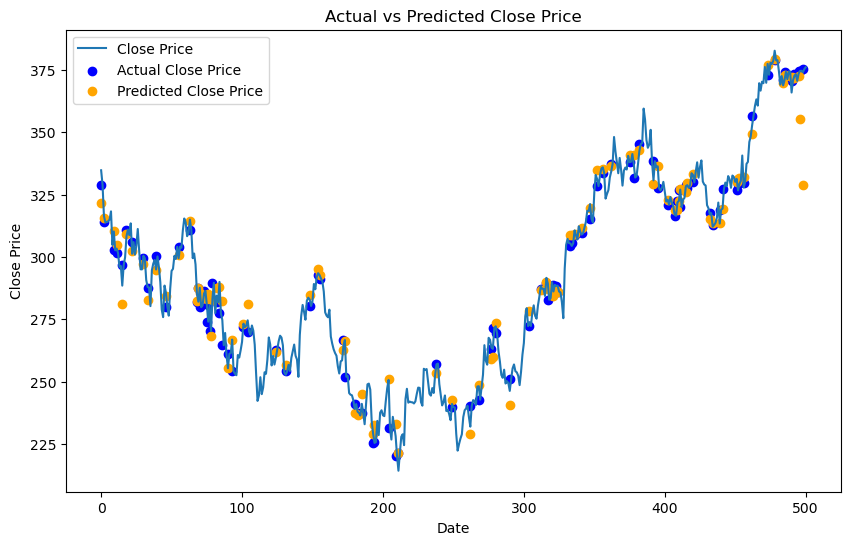

In [12]:
# Create a DataFrame with actual and predicted values for plotting
df_plot = pd.DataFrame({
    'Actual Close Price': y_test,
    'Predicted Close Price': y_test_pred
})

# Print the DataFrame
#print(df_plot)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price')
plt.scatter(df_plot.index, df_plot['Actual Close Price'], label='Actual Close Price', color='blue', marker='o')
plt.scatter(df_plot.index, df_plot['Predicted Close Price'], label='Predicted Close Price', color='orange', marker='o')
plt.xlabel('Date') 
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()

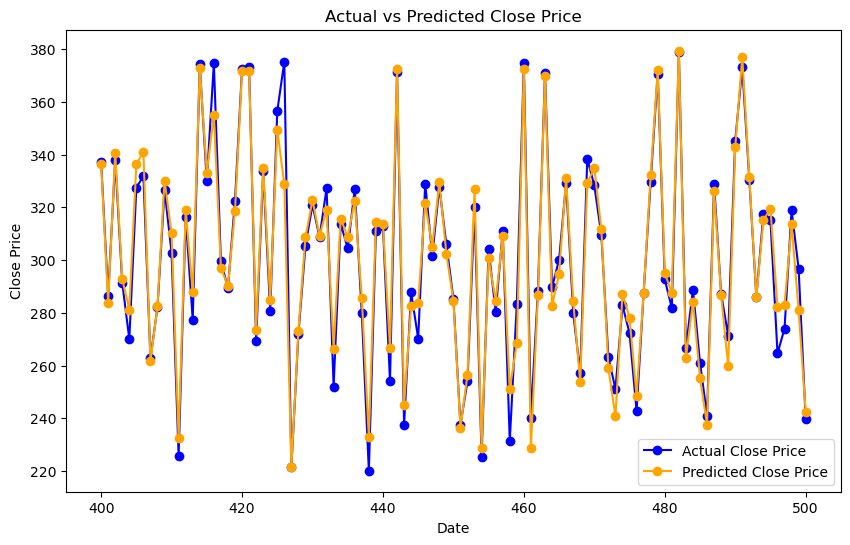

In [13]:

# Create a DataFrame with actual and predicted values for plotting
df_plot = pd.DataFrame({
    'Date': data.index[-len(X_test):],
    'Actual Close Price': y_test,
    'Predicted Close Price': y_test_pred
})

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_plot['Date'], df_plot['Actual Close Price'], label='Actual Close Price', color='blue', marker='o')
plt.plot(df_plot['Date'], df_plot['Predicted Close Price'], label='Predicted Close Price', color='orange', marker='o')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()